In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from transformers import AdamW
import pandas as pd
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import csv
import re
import validators
import emoji
import unidecode
import nltk
import pickle
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Set the seed for reproducibility
SEED = 1237
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# BERT Hyperparameters (ADDITION)
n_bert_layers = 24  # Assuming the base model has 12 layers
bert_lr = 0.001
pooling_strategy = 'cls'  # Options: 'cls', 'mean', 'max'
bert_hidden_size = 768  # Adjust based on your BERT model
max_seq_length = 128
fine_tune_strategy = 'full'  # Options: 'full', 'last_layer'
bert_dropout = 0.9  # Adjust based on BERT model specifications

max_seq_length = 128  # This should match the max_seq_length used in BERT model
padding_strategy = 'max_length'  # Options: 'max_length', 'do_not_pad', 'longest'
truncation_strategy = 'longest_first'  # Options: 'longest_first', 'only_first', 'only_second'
do_lower_case = True  # Set to False if using a cased model

config = BertConfig(
    num_hidden_layers=n_bert_layers,
    hidden_size=bert_hidden_size,
    num_attention_heads=24,  # Assuming 12 attention heads
    intermediate_size=4 * bert_hidden_size,  # Default value in BERT
    hidden_dropout_prob=bert_dropout,
    attention_probs_dropout_prob=bert_dropout,
)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          max_length=max_seq_length,
                                          padding=padding_strategy,
                                          truncation=truncation_strategy,
                                          do_lower_case=do_lower_case)
# Load the BERT model with the custom configuration
bert_model = BertModel(config=config)


In [3]:
### used multi-label dataset

In [4]:
data_path = "C:/Users/Mai/thesis/ch 4/multilabel-dataset.csv" 
data_df = pd.read_csv(data_path)
data_df = data_df.rename(columns={'Tweet Content': 'text', 'Sentiment': 'sentiment'})

In [5]:
##data_df.head()

In [6]:
##groupedby_sentiment = data_df.groupby(data_df.sentiment)
##data_df_positive = groupedby_sentiment.get_group("Positive")
##data_df_positive

In [7]:
##data_df_negative = groupedby_sentiment.get_group("Negative")
##data_df_negative

In [8]:
##data_df_neutral = groupedby_sentiment.get_group("Neutral")
##data_df_neutral

In [9]:
## binary hate non-hate
##data_df_hate = data_df_negative.sample(n = 2560)

##data_df_positive = data_df_positive.sample(n = 2560)
##data_df_neutral = data_df_neutral.sample(n = 2560)

##data_df_nonhate = data_df_positive.append(data_df_neutral)

##data_df = data_df_hate.append(data_df_nonhate)

In [10]:
##data_df = data_df.drop(['Label'], axis = 1)

In [11]:
#data_df.to_csv('dataset.csv', index=False)
data_df

text sentiment     Label
0     Dictator's son on the cusp of power in the #Ph...  Negative      Hate
1     Kung ang definition ni BongBong Marcos sa isan...  Negative      Hate
2     Leni Robredo is not being subjected by her opp...  Negative      Hate
3     @imstillsour Tuwang tuwa sila sa Pink hahaha.....  Negative      Hate
4     Kapag hindi si VP Leni Robredo ang iboboto mo ...  Negative      Hate
...                                                 ...       ...       ...
7675   VP LENI ROBREDO FOR 2022 https://t.co/2ahSefgmST   Neutral  Non-hate
7676  @alt_ego143 @rapplerdotcom @ramboreports hindi...   Neutral  Non-hate
7677  I can't vote yet, but my president is Leni Rob...   Neutral  Non-hate
7678  Anyways President Leni Robredo #SaveLegendsOfT...   Neutral  Non-hate
7679  Kung ayaw nyo d wag nyo iboto.Napaka simple.. ...   Neutral  Non-hate

[7680 rows x 3 columns]

In [12]:
##data_df = data_df.reset_index()

In [13]:
##data_df

In [14]:
# data_df = "dataset.csv"

In [15]:
# Preprocessing function
def preprocess_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = tokens[:tokenizer.model_max_length - 2]  # Account for [CLS] and [SEP] tokens
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
    return indexed_tokens

filipino_stopwords = set(
    """
akin
aking
ako
alin
am
amin
aming
ang
ano
anumang
apat
at
atin
ating
ay
bababa
bago
bakit
bawat
bilang
dahil
dalawa
dapat
din
dito
doon
gagawin
gayunman
ginagawa
ginawa
ginawang
gumawa
gusto
habang
hanggang
hindi
huwag
iba
ibaba
ibabaw
ibig
ikaw
ilagay
ilalim
ilan
inyong
isa
isang
itaas
ito
iyo
iyon
iyong
ka
kahit
kailangan
kailanman
kami
kanila
kanilang
kanino
kanya
kanyang
kapag
kapwa
karamihan
katiyakan
katulad
kaya
kaysa
ko
kong
kulang
kumuha
kung
laban
lahat
lamang
likod
lima
maaari
maaaring
maging
mahusay
makita
marami
marapat
masyado
may
mayroon
mga
minsan
mismo
mula
muli
na
nabanggit
naging
nagkaroon
nais
nakita
namin
napaka
narito
nasaan
ng
ngayon
ni
nila
nilang
nito
niya
niyang
noon
o
pa
paano
pababa
paggawa
pagitan
pagkakaroon
pagkatapos
palabas
pamamagitan
panahon
pangalawa
para
paraan
pareho
pataas
pero
pumunta
pumupunta
sa
saan
sabi
sabihin
sarili
sila
sino
siya
tatlo
tayo
tulad
tungkol
una
walang
""".split()
)

# from nltk.corpus import stopwords
# english_stopwords = stopwords.words('english')

# search = "leni robredo bongbong marcos isko moreno domagoso manny pacman pacquiao ping lacson ernie abella leody de guzman norberto gonzales jose montemayor jr faisal mangondato"
# candidatelist = search.split(" ")

# URL Removal
def remove_url (text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    
    # Use re.sub to replace URLs with an empty string
    return url_pattern.sub('', text)

# Emoji Removal
def replace_emojis(text):
    return emoji.replace_emoji(text, "")

# Remove Diacritics
def remove_diacritics(text):
    return unidecode.unidecode(text)

# Remove English Stop Words
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

def remove_english_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Remove Filipino Stop Words
def remove_filipino_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in filipino_stopwords]
    return ' '.join(filtered_words)

In [16]:
#PreProcessing

# URL Removal
data_df['text'] = data_df['text'].apply(remove_url)

# Emoji Removal
data_df['text'] = data_df['text'].apply(replace_emojis)

 # Lowercase
data_df['text'] = data_df['text'].str.lower()

# Remove Diacritics
data_df['text'] = data_df['text'].apply(remove_diacritics)

# Remove symbols and numerics using regex
#data_df['text'] = data_df['text'].str.replace(r'[^A-Za-z\s#]', '', regex=True)
data_df['text'] = data_df['text'].str.replace(r'[^a-zA-Z0-9\s!?]', '', regex=True)

# Remove English Stop Words
#data_df['text'] = data_df['text'].apply(remove_english_stopwords)

# Remove Filipino Stop Words
data_df['text'] = data_df['text'].apply(remove_filipino_stopwords)

data_df.to_csv('sample5.csv', index=False)


data_df['text'] = data_df['text'].apply(preprocess_text)

In [17]:
data_df

text sentiment     Label
0     [21237, 2015, 2365, 2006, 1996, 12731, 13102, ...  Negative      Hate
1     [6210, 14753, 18259, 5063, 14810, 28774, 21239...  Negative      Hate
2     [18798, 2072, 6487, 23417, 2003, 2025, 2108, 1...  Negative      Hate
3     [10047, 16643, 12718, 8162, 10722, 16600, 1072...  Negative      Hate
4     [9033, 21210, 18798, 2072, 6487, 23417, 21307,...  Negative      Hate
...                                                 ...       ...       ...
7675  [21210, 18798, 2072, 6487, 23417, 2005, 16798,...   Neutral  Non-hate
7676  [12456, 20265, 16932, 2509, 9680, 10814, 20683...   Neutral  Non-hate
7677  [1045, 2064, 2102, 3789, 2664, 2021, 2026, 234...   Neutral  Non-hate
7678  [4312, 2015, 2343, 18798, 2072, 6487, 23417, 3...   Neutral  Non-hate
7679  [1037, 3148, 2860, 6396, 2080, 1040, 11333, 22...   Neutral  Non-hate

[7680 rows x 3 columns]

In [18]:
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=SEED)

In [19]:
### changed output_dim=3, added torch.softmax

In [20]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_dropout = nn.Dropout(dropout) 
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=256, kernel_size=2, padding='same')
        self.pool1 = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=64, kernel_size=4, padding='same')
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        x = embedded.permute(0, 2, 1)  # Change the dimensions for convolution
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.global_pooling(x).squeeze(2)
        x = self.dropout(x)
        x = self.fc(x)
        x = torch.softmax(x, dim=1)
        
        return x

In [21]:
# Set up iterators
BATCH_SIZE = 64

In [22]:
### changed "label" to "sentiment"

In [23]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, max_seq_length):
        self.data = dataframe
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        sentiment = self.data.iloc[idx]['sentiment']

        # Padding and conversion to tensor
        padded_text = torch.tensor(text[:self.max_seq_length] + [0] * (self.max_seq_length - len(text)))
        return padded_text, sentiment

In [24]:
train_dataset = TextDataset(train_df, 1000)
test_dataset = TextDataset(test_df, 1000)

In [25]:
train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [26]:
# Define model hyperparameters
VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 768
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 3
DROPOUT = 0.5

# CNN Hyperparameters
hidden_dim = 100
n_conv_layers = 1
kernel_sizes = [2, 3, 4]
activation = nn.ReLU()

In [27]:
# Initialize CNN model
model = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)
#Initialize CNN model
# model = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, hidden_dim, n_conv_layers, kernel_sizes, activation)

In [28]:
# Initialize BERT model (for embedding extraction)
bert_model.eval()  # Set to evaluation mode

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.9, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-23): 24 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.9, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.9, inplace=False)
  

In [29]:
with torch.no_grad():
    for i, token in enumerate(tokenizer.get_vocab()):
        token_id = tokenizer.convert_tokens_to_ids(token)
        token_embedding = bert_model.embeddings.word_embeddings.weight[token_id]
        model.embedding.weight[i].data.copy_(token_embedding)

bert_parameters = []
for layer in bert_model.encoder.layer:
    bert_parameters.extend(layer.parameters())

# Create AdamW optimizer with custom hyperparameters for BERT embeddings
bert_learning_rate = 2e-4  # Adjust as needed
bert_optimizer = optim.AdamW(bert_parameters, lr=bert_learning_rate)

In [30]:
data_df

text sentiment     Label
0     [21237, 2015, 2365, 2006, 1996, 12731, 13102, ...  Negative      Hate
1     [6210, 14753, 18259, 5063, 14810, 28774, 21239...  Negative      Hate
2     [18798, 2072, 6487, 23417, 2003, 2025, 2108, 1...  Negative      Hate
3     [10047, 16643, 12718, 8162, 10722, 16600, 1072...  Negative      Hate
4     [9033, 21210, 18798, 2072, 6487, 23417, 21307,...  Negative      Hate
...                                                 ...       ...       ...
7675  [21210, 18798, 2072, 6487, 23417, 2005, 16798,...   Neutral  Non-hate
7676  [12456, 20265, 16932, 2509, 9680, 10814, 20683...   Neutral  Non-hate
7677  [1045, 2064, 2102, 3789, 2664, 2021, 2026, 234...   Neutral  Non-hate
7678  [4312, 2015, 2343, 18798, 2072, 6487, 23417, 3...   Neutral  Non-hate
7679  [1037, 3148, 2860, 6396, 2080, 1040, 11333, 22...   Neutral  Non-hate

[7680 rows x 3 columns]

In [31]:
### changed nn.BCEWithLogitsLoss to nn.CrossEntropyLoss

In [32]:
#optimizer = optim.Adam(model.parameters())
# Your custom hyperparameters
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-08
weight_decay = 0.0

# Create Adam optimizer with custom hyperparameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=epsilon, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [33]:
### added dictionary
### changed from binary to multilabel in train and eval 
### changed calculation of accuracy, f1, precision, recall 

In [34]:
# Create a dictionary to map class labels to numerical indices
label_to_index = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}

# Train function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, iterator):
    model.train()
    epoch_loss = 0
    for text_batch, sentiment_batch in iterator:
        # Extract text sequences from the text_batch tensor
        texts = text_batch
        
        # BINARY
        ## Extract and process labels
        ## labels = [1 if label == 'Hate' else 0 for label in label_batch]  # Example conversion
        
        # MULTILBAEL
        # Use numerical labels for multi-class classification
        labels = torch.tensor([label_to_index[sentiment] for sentiment in sentiment_batch]).to(device)

        texts = texts.to(device)  # Move to device if needed
        ## labels = torch.tensor(labels, dtype=torch.float32).to(device)  # Convert to tensor
        
        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)
        
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)


# Evaluate function
def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0
    predicted_sentiments = []
    true_sentiments = []  # Declare the true_sentiments list
    
    with torch.no_grad():
        for text_batch, sentiment_batch in iterator:
            texts = text_batch  # Extract text sequences
            
            ## labels = [1 if label == 'Hate' else 0 for label in label_batch]  # Example conversion
            
            # Use numerical labels for multi-class classification
            labels = torch.tensor([label_to_index[sentiment] for sentiment in sentiment_batch]).to(device)
            
            texts = texts.to(device)  # Move to device
            ## labels = torch.tensor(labels, dtype=torch.float32).to(device)  # Convert to tensor
            
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            
            ## predicted_labels.extend(torch.round(torch.sigmoid(predictions)).cpu().numpy())
            ## true_labels.extend(labels.cpu().numpy())
            
            # Convert predictions to class labels
            predicted_sentiments.extend([list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx in torch.argmax(predictions, dim=1).cpu().numpy()])
            true_sentiments.extend([list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx in labels.cpu().numpy()])
    
    # Calculate accuracy, f1, precision, recall
    
    ##accuracy = accuracy_score(true_labels, predicted_labels)
    ##f1 = f1_score(true_labels, predicted_labels)
    ##precision = precision_score(true_labels, predicted_labels)
    ##recall = recall_score(true_labels, predicted_labels)
    
    # Calculate accuracy, f1, precision, recall
    accuracy = accuracy_score(true_sentiments, predicted_sentiments)
    f1 = f1_score(true_sentiments, predicted_sentiments, average='macro')
    precision = precision_score(true_sentiments, predicted_sentiments, average='macro')
    recall = recall_score(true_sentiments, predicted_sentiments, average='macro')
    
    return epoch_loss / len(iterator), accuracy, f1, precision, recall, predicted_sentiments, true_sentiments

In [35]:
### revised

D:\Users\Mai\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch: 01

	Train Loss: 1.028
	Test Loss: 0.958

	Accuracy: 0.5629 | F1-Score: 0.5028
	Precision: 0.5132 | Recall: 0.5639

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6236    0.8115    0.7053       780
    Negative     0.3716    0.1049    0.1636       772
     Neutral     0.5444    0.7753    0.6396       752

    accuracy                         0.5629      2304
   macro avg     0.5132    0.5639    0.5028      2304
weighted avg     0.5133    0.5629    0.5024      2304


[[633  79  68]
 [271  81 420]
 [111  58 583]]


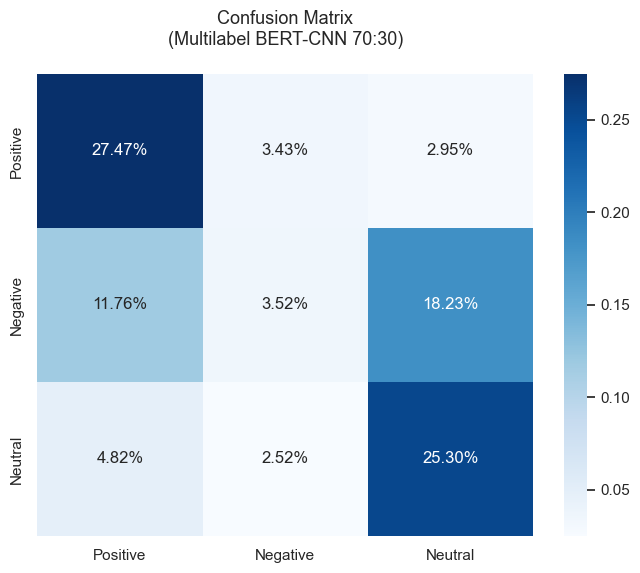

Epoch: 02

	Train Loss: 0.930
	Test Loss: 0.932

	Accuracy: 0.5859 | F1-Score: 0.5495
	Precision: 0.5581 | Recall: 0.5862

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6440    0.8372    0.7280       780
    Negative     0.4600    0.2085    0.2870       772
     Neutral     0.5702    0.7128    0.6336       752

    accuracy                         0.5859      2304
   macro avg     0.5581    0.5862    0.5495      2304
weighted avg     0.5583    0.5859    0.5494      2304


[[653  78  49]
 [256 161 355]
 [105 111 536]]


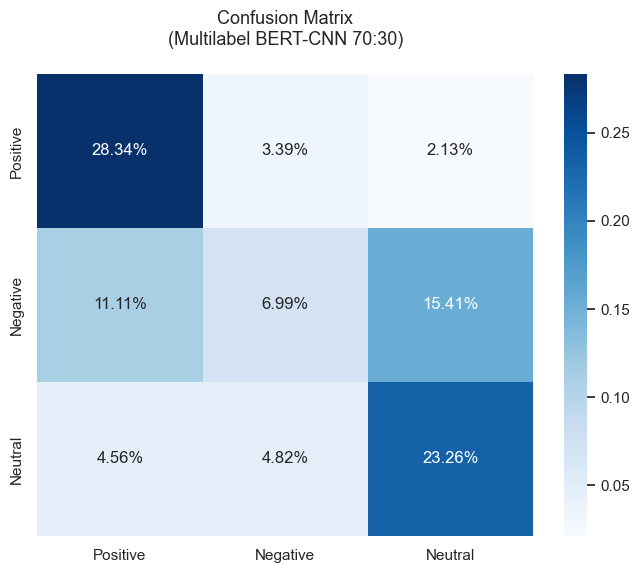

Epoch: 03

	Train Loss: 0.867
	Test Loss: 0.918

	Accuracy: 0.6185 | F1-Score: 0.6091
	Precision: 0.6069 | Recall: 0.6186

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7093    0.7756    0.7410       780
    Negative     0.5000    0.3899    0.4381       772
     Neutral     0.6113    0.6902    0.6483       752

    accuracy                         0.6185      2304
   macro avg     0.6069    0.6186    0.6091      2304
weighted avg     0.6072    0.6185    0.6093      2304


[[605 141  34]
 [175 301 296]
 [ 73 160 519]]


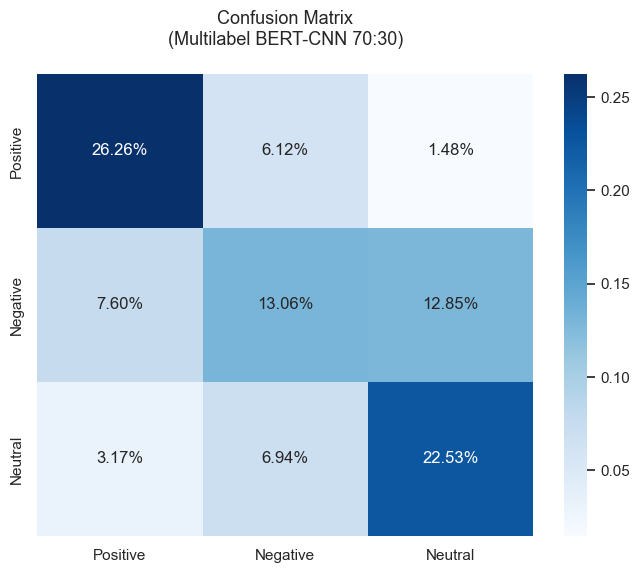

Epoch: 04

	Train Loss: 0.816
	Test Loss: 0.913

	Accuracy: 0.6172 | F1-Score: 0.6182
	Precision: 0.6261 | Recall: 0.6161

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7275    0.7462    0.7367       780
    Negative     0.4820    0.5544    0.5157       772
     Neutral     0.6688    0.5479    0.6023       752

    accuracy                         0.6172      2304
   macro avg     0.6261    0.6161    0.6182      2304
weighted avg     0.6261    0.6172    0.6188      2304


[[582 183  15]
 [155 428 189]
 [ 63 277 412]]


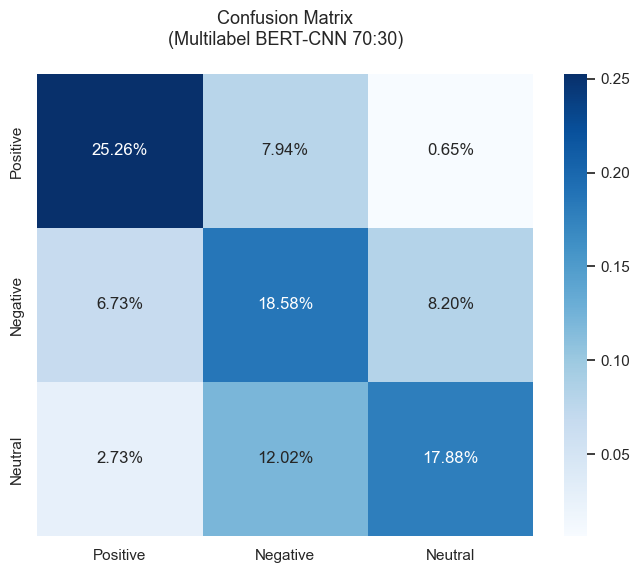

Epoch: 05

	Train Loss: 0.770
	Test Loss: 0.898

	Accuracy: 0.6341 | F1-Score: 0.6330
	Precision: 0.6329 | Recall: 0.6336

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7269    0.7577    0.7420       780
    Negative     0.5156    0.5142    0.5149       772
     Neutral     0.6560    0.6290    0.6422       752

    accuracy                         0.6341      2304
   macro avg     0.6329    0.6336    0.6330      2304
weighted avg     0.6330    0.6341    0.6333      2304


[[591 161  28]
 [155 397 220]
 [ 67 212 473]]


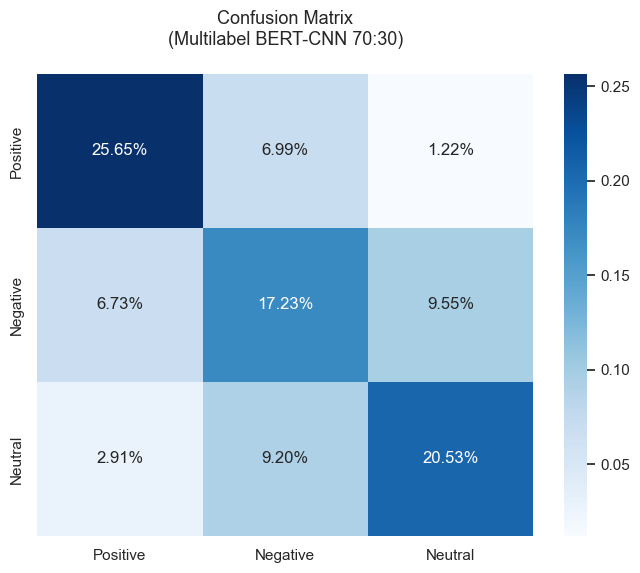

Epoch: 06

	Train Loss: 0.747
	Test Loss: 0.908

	Accuracy: 0.6246 | F1-Score: 0.6296
	Precision: 0.6403 | Recall: 0.6246

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7842    0.6615    0.7177       780
    Negative     0.4889    0.5712    0.5269       772
     Neutral     0.6478    0.6410    0.6444       752

    accuracy                         0.6246      2304
   macro avg     0.6403    0.6246    0.6296      2304
weighted avg     0.6408    0.6246    0.6298      2304


[[516 234  30]
 [ 99 441 232]
 [ 43 227 482]]


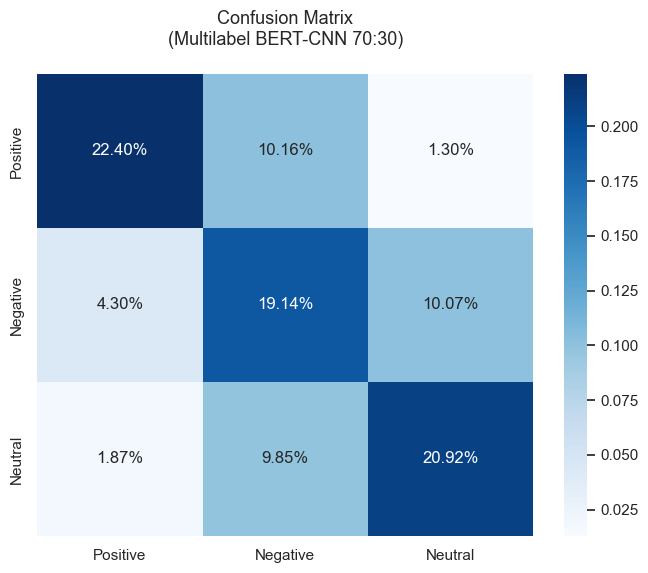

Epoch: 07

	Train Loss: 0.723
	Test Loss: 0.899

	Accuracy: 0.6380 | F1-Score: 0.6382
	Precision: 0.6461 | Recall: 0.6369

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7256    0.7628    0.7438       780
    Negative     0.5143    0.5842    0.5470       772
     Neutral     0.6985    0.5638    0.6240       752

    accuracy                         0.6380      2304
   macro avg     0.6461    0.6369    0.6382      2304
weighted avg     0.6459    0.6380    0.6387      2304


[[595 172  13]
 [151 451 170]
 [ 74 254 424]]


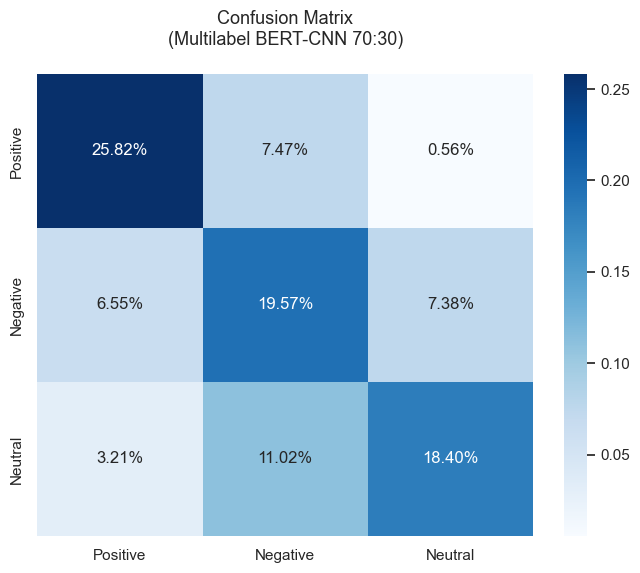

Epoch: 08

	Train Loss: 0.706
	Test Loss: 0.907

	Accuracy: 0.6306 | F1-Score: 0.6335
	Precision: 0.6390 | Recall: 0.6302

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7544    0.7128    0.7330       780
    Negative     0.5011    0.5648    0.5311       772
     Neutral     0.6614    0.6130    0.6363       752

    accuracy                         0.6306      2304
   macro avg     0.6390    0.6302    0.6335      2304
weighted avg     0.6392    0.6306    0.6338      2304


[[556 201  23]
 [123 436 213]
 [ 58 233 461]]


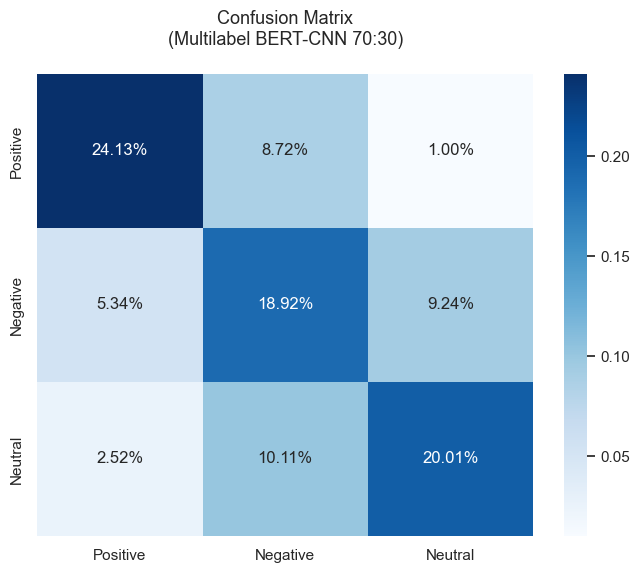

Epoch: 09

	Train Loss: 0.697
	Test Loss: 0.901

	Accuracy: 0.6341 | F1-Score: 0.6355
	Precision: 0.6375 | Recall: 0.6339

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7460    0.7192    0.7324       780
    Negative     0.5129    0.5402    0.5262       772
     Neutral     0.6536    0.6423    0.6479       752

    accuracy                         0.6341      2304
   macro avg     0.6375    0.6339    0.6355      2304
weighted avg     0.6377    0.6341    0.6357      2304


[[561 188  31]
 [130 417 225]
 [ 61 208 483]]


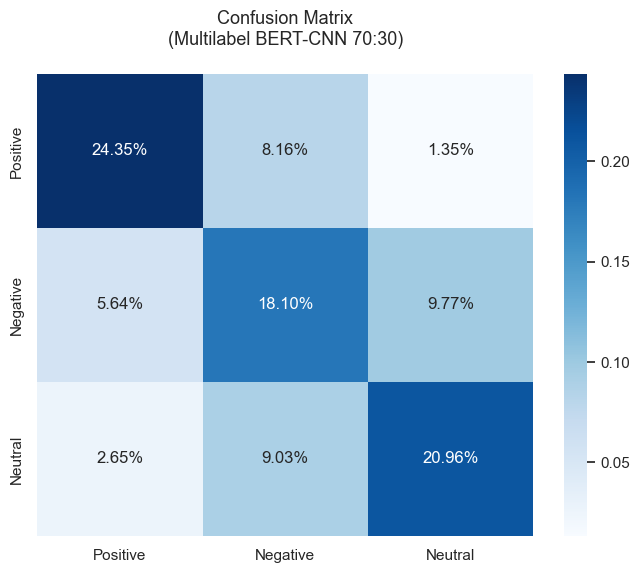

Epoch: 10

	Train Loss: 0.690
	Test Loss: 0.893

	Accuracy: 0.6437 | F1-Score: 0.6452
	Precision: 0.6500 | Recall: 0.6430

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7448    0.7333    0.7390       780
    Negative     0.5272    0.5907    0.5571       772
     Neutral     0.6781    0.6051    0.6395       752

    accuracy                         0.6437      2304
   macro avg     0.6500    0.6430    0.6452      2304
weighted avg     0.6501    0.6437    0.6456      2304


[[572 183  25]
 [125 456 191]
 [ 71 226 455]]


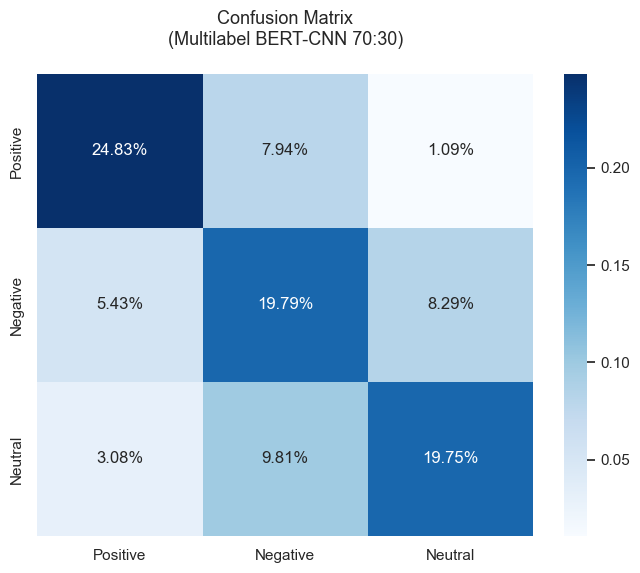

In [36]:
from sklearn.metrics import classification_report

N_EPOCHS = 10
predicted_sentiments_per_epoch = []
true_sentiments_per_epoch = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator)
    test_loss, accuracy, f1, precision, recall, predicted_sentiments, true_sentiments = evaluate(model, test_iterator)
    
    # Save the predicted_sentiments and true_sentiments for the current epoch
    predicted_sentiments_per_epoch.append(predicted_sentiments)
    true_sentiments_per_epoch.append(true_sentiments)

    # Print other metrics (e.g., accuracy, loss) for the current epoch
    print(f'Epoch: {epoch + 1:02}\n')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tTest Loss: {test_loss:.3f}\n')
    print(f'\tAccuracy: {accuracy:.4f} | F1-Score: {f1:.4f}')
    print(f'\tPrecision: {precision:.4f} | Recall: {recall:.4f}\n')
    print(f'\tClassification Report:\n')
    report = classification_report(true_sentiments, predicted_sentiments, target_names=['Positive', 'Negative', 'Neutral'], digits = 4)
    print(f'{report}\n')
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np  # Import numpy for matrix normalization

    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(true_sentiments, predicted_sentiments)
    print(cf_matrix)

    # Plot the confusion matrix using seaborn
    sns.set(rc={"figure.figsize": (8, 6)})  # Add a closing parenthesis to set
    ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'], fmt='.2%', cmap='Blues')

    plt.title('Confusion Matrix\n(Multilabel BERT-CNN 70:30)\n', fontsize=13)
    plt.show()